In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt 

from dedalus import public as de
from dedalus.extras import plot_tools

In [11]:
# Domain
L = 20
h = 100

# Wavenumber
k = 0.1

# Numerics
nx = 32
nz = 32

In [12]:
# Create bases and domain
x_basis = de.Fourier('x',   nx, interval=(-L/2, L/2))
z_basis = de.Chebyshev('z', nz, interval=(-h, 0)) 

domain = de.Domain([x_basis, z_basis], grid_dtype=np.float64)

# The McIntyre flow

We solve Laplace's equation for $\phi_2$ with a Neumann bottom boundary condition and a top boundary condition

$$ \phi_{2z} = \frac{\sigma_k}{g} \partial_x \overline{ | \boldsymbol{u}_1 |^2 }$$

at $z=0$.

But $\boldsymbol{u} = \boldsymbol{\nabla} \phi_1$, where

$$ \phi_1(x, z, t) = a e^{-x^2 / 2 \ell^2} \cos( \left [ kx - (\sigma - k \sigma_k ) t \right ] \frac{\cosh k(z+h)}{\cosh kh} $$

This means that

$$ u_1 \approx - a k e^{-x^2 / 2 \ell^2} \sin \left [ kx - (\sigma - k \sigma_k) t \right ] \frac{\cosh{[k(z+h)]}}{\cosh kh}
\qquad \text{and} \qquad 
w_1 = a k e^{-x^2 / 2 \ell^2} \cos \left [ kx - (\sigma - k \sigma_k ) t \right ] \frac{\sinh{[k(z+h)]}}{\cosh kh}$$. 

Therefore

$$ | \boldsymbol{u}_1 |^2 = u_1^2 + w_1^2 = \frac{1}{2} (a k)^2 e^{-x^2 / \ell^2} \frac{\cosh{[2k(z+h)]}}{\cosh^2(kh)}$$

and

$$ \partial_x | \boldsymbol{u}_1 |^2 =  - \frac{(ak)^2}{\ell^2} x\,e^{-x^2 / \ell^2}  \frac{\cosh{[2k(z+h)]}}{\cosh^2kh}$$

The Stokes drift is defined in terms of the particle displacement $\boldsymbol{\xi}_{1t} = \boldsymbol{u}_1$,

$$ \xi_1 = - \frac{a k}{\sigma - k \sigma_k} e^{-x^2 / 2 \ell^2} \cos \left [ kx - (\sigma - k \sigma_k) t \right ] \frac{\cosh{[k(z+h)]}}{\cosh kh}
\qquad \text{and} \qquad
\zeta_1 = - \frac{a k}{\sigma - k \sigma_k} e^{-x^2 / 2 \ell^2} \sin \left [ kx - (\sigma - k \sigma_k ) t \right ] \frac{\sinh{[k(z+h)]}}{\cosh kh}$$

$$ \boldsymbol{u}^\mathrm{S} = \overline{ \boldsymbol{\xi}_1 \cdot \boldsymbol{\nabla} \boldsymbol{u}_1}$$

Therefore

$$u^\mathrm{S} = \overline{\xi_1 u_{1x}} + \overline{\zeta_1 u_{1z}} = \frac{k (ak)^2}{2(\sigma - k \sigma_k)} e^{-x^2 / \ell^2} \frac{\cosh[2k(z+h)]}{2\cosh^2h k}$$

and

$$w^\mathrm{S} = \overline{\xi_1 w_{1x}} + \overline{\zeta_1 w_{1z}} = \frac{(ak)^2}{4\ell^2(\sigma - k \sigma_k)} x\, e^{-x^2 / \ell^2} \frac{\sinh[2k(z+h)]}{2\cosh^2h k}$$




In [13]:
problem = de.LBVP(domain, variables=['Φ', 'Φz'])

problem.parameters["k"] = k
problem.parameters["h"] = h

problem.substitutions["dx_u1_squared"] = "- exp(-x**2) * x * (1 + (tanh(k*h)**2))"

problem.add_equation("dx(dx(Φ)) + dz(Φz) = 0", condition="(nx != 0)")

problem.add_equation("Φ = 0", condition="(nx == 0)")
problem.add_equation("Φz = 0", condition="(nx == 0)")
problem.add_equation("dz(Φ) - Φz = 0", condition="(nx != 0)")

problem.add_bc("left(Φz) = 0", condition="(nx != 0)")
problem.add_bc("right(Φz) = dx_u1_squared", condition="(nx != 0)")

# Build solver
solver = problem.build_solver()
solver.solve()

2020-06-01 13:26:08,945 pencil 0/1 INFO :: Building pencil matrix 1/16 (~6%) Elapsed: 0s, Remaining: 0s, Rate: 9.2e+01/s
2020-06-01 13:26:08,962 pencil 0/1 INFO :: Building pencil matrix 2/16 (~12%) Elapsed: 0s, Remaining: 0s, Rate: 7.2e+01/s
2020-06-01 13:26:08,990 pencil 0/1 INFO :: Building pencil matrix 4/16 (~25%) Elapsed: 0s, Remaining: 0s, Rate: 7.2e+01/s
2020-06-01 13:26:09,017 pencil 0/1 INFO :: Building pencil matrix 6/16 (~38%) Elapsed: 0s, Remaining: 0s, Rate: 7.2e+01/s
2020-06-01 13:26:09,042 pencil 0/1 INFO :: Building pencil matrix 8/16 (~50%) Elapsed: 0s, Remaining: 0s, Rate: 7.4e+01/s
2020-06-01 13:26:09,062 pencil 0/1 INFO :: Building pencil matrix 10/16 (~62%) Elapsed: 0s, Remaining: 0s, Rate: 7.8e+01/s
2020-06-01 13:26:09,084 pencil 0/1 INFO :: Building pencil matrix 12/16 (~75%) Elapsed: 0s, Remaining: 0s, Rate: 8.0e+01/s
2020-06-01 13:26:09,103 pencil 0/1 INFO :: Building pencil matrix 14/16 (~88%) Elapsed: 0s, Remaining: 0s, Rate: 8.3e+01/s
2020-06-01 13:26:09,13

In [14]:
problem2 = de.LBVP(domain, variables=['ψ', 'ψz'])

Φz = solver.state['Φz']

problem2.parameters["Φz"] = Φz

problem2.add_equation("dx(dx(ψ)) + dz(ψz) = 0", condition="(nx != 0)")

problem2.add_equation("ψ = 0", condition="(nx == 0)")
problem2.add_equation("ψz = 0", condition="(nx == 0)")
problem2.add_equation("dz(ψ) - ψz = 0", condition="(nx != 0)")

problem2.add_bc("left(dx(ψ)) = 0", condition="(nx != 0)")
problem2.add_bc("right(dx(ψ)) = interp(Φz, z=0)", condition="(nx != 0)")

# Build solver
solver2 = problem2.build_solver()
solver2.solve()

2020-06-01 13:26:09,252 pencil 0/1 INFO :: Building pencil matrix 1/16 (~6%) Elapsed: 0s, Remaining: 0s, Rate: 1.5e+02/s
2020-06-01 13:26:09,271 pencil 0/1 INFO :: Building pencil matrix 2/16 (~12%) Elapsed: 0s, Remaining: 0s, Rate: 7.6e+01/s
2020-06-01 13:26:09,303 pencil 0/1 INFO :: Building pencil matrix 4/16 (~25%) Elapsed: 0s, Remaining: 0s, Rate: 6.9e+01/s
2020-06-01 13:26:09,329 pencil 0/1 INFO :: Building pencil matrix 6/16 (~38%) Elapsed: 0s, Remaining: 0s, Rate: 7.1e+01/s
2020-06-01 13:26:09,352 pencil 0/1 INFO :: Building pencil matrix 8/16 (~50%) Elapsed: 0s, Remaining: 0s, Rate: 7.5e+01/s
2020-06-01 13:26:09,372 pencil 0/1 INFO :: Building pencil matrix 10/16 (~62%) Elapsed: 0s, Remaining: 0s, Rate: 7.8e+01/s
2020-06-01 13:26:09,398 pencil 0/1 INFO :: Building pencil matrix 12/16 (~75%) Elapsed: 0s, Remaining: 0s, Rate: 7.9e+01/s
2020-06-01 13:26:09,419 pencil 0/1 INFO :: Building pencil matrix 14/16 (~88%) Elapsed: 0s, Remaining: 0s, Rate: 8.0e+01/s
2020-06-01 13:26:09,44

In [15]:
Φ = solver.state['Φ']
ψ = solver2.state['ψ']

u_op = de.operators.differentiate(Φ, x=1)
w_op = de.operators.differentiate(Φ, z=1)

u = u_op.evaluate()
w = w_op.evaluate()

(-10.0, 0.0)

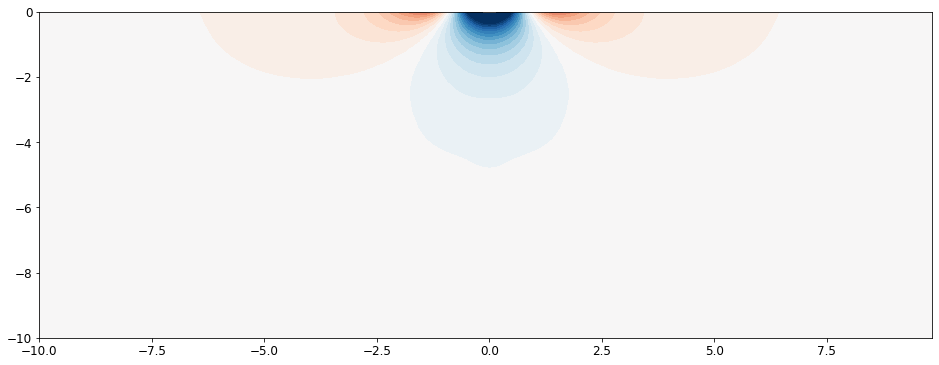

In [17]:
# Plot solution
plt.rcParams.update({'font.size': 12})

fig, axs = plt.subplots(ncols=1, figsize=(16, 6), sharey=True) 
scale = 4 

x = domain.grid(0, scales=scale)
#y = domain.grid(1, scales=scale)
z = domain.grid(1, scales=scale)

X, Z = np.meshgrid(x, z)

Φ.set_scales(scale)
Φ.require_grid_space()

ψ.set_scales(scale)
ψ.require_grid_space()

u.set_scales(scale)
u.require_grid_space()

w.set_scales(scale)
w.require_grid_space()

ulim = 0.6
levs = np.linspace(-1, 1, 50)

plt.sca(axs)

im0 = plt.contourf(X, Z, u['g'][:, :].T, cmap="RdBu_r", vmin=-ulim, vmax=ulim, levels=levs)
plt.ylim(-10, 0)